# Household Behavior over the Life Cycle Exam 2025.
## Suggested answers

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.optimize import minimize, minimize_scalar, root_scalar
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

## Question 1
The model can be formulated this way because it does not matter for the current choices over consumption and portfolio allocation which combination of asset allocation that has generated the current available resources. Whether it was through riskless or risky assets does not matter, and we can just keep track of the total savings in $s_t=a_t+b_t$. Had the model included e.g. transaction costs, then this would not be true.

## Question 2
The expected value is an integral over continuous shocks to the risky assets,
\begin{equation}
\mathbb{E}_t[V_{t+1}(s_{t+1},R^b_{t+1})]=\int_{-\infty}^{\infty}V_{t+1}(s_{t+1}(\varepsilon_t),\max\{R^b_{t}+\varepsilon_t,0.0\})\cdot\phi(\varepsilon_t/\sigma)d\varepsilon_t
\end{equation}
where $\phi(\bullet)$ is the standard Normal pdf, the return transition in equation (5) have been inserted and the dependence of $s_{t+1}$ on $\varepsilon_t$ is indicated by $s_{t+1}(\varepsilon_t)$.

We can approximate the integral numerically on the computer by transforming the integral into a discrete sum,
\begin{equation}
\mathbb{E}_t[V_{t+1}(s_{t+1},R^b_{t+1})]\approx\sum_{j=1}^{J}V_{t+1}(s_{t+1}(\varepsilon_t^j),\max\{R^b_{t}+\varepsilon_t^j,0.0\})\cdot\omega^j
\end{equation}
where $\varepsilon_t^j$ denotes evaluation nodes and $\omega^j$ are associated weights/probabilities for a given outcome. 

We can e.g. use Monte Carlo simulation and draw $J$ random $\varepsilon_t^j$ from a Normal distribution with zero mean and variance $\sigma^2$ and set all weights equal, $\omega^j=1/J$. Alternatively, as done in the code, we can use Gaussian Quadrature and pick nodes and weights "optimally" under certain conditions.

We use linear interpolation to interpolate between known nodes when the evaluation nodes lie between the know grid nodes in the state space.

## Question 3

In [2]:
from PortfolioModel_post import PortfolioModelClass
# baseline model
model = PortfolioModelClass(par={'tau':0.0,'Nr':1})
model.solve()
model.simulate()

# model without any risk of "risky" asset
model_norisk = PortfolioModelClass(par={'tau':0.0,'Nr':1,'sigma2': 0.0})
model_norisk.solve()
model_norisk.simulate()

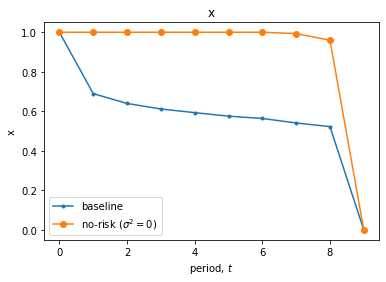

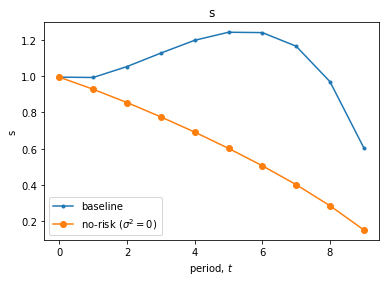

In [3]:
# plot the simulated behavior
for var in ('x','s'):
    fig,ax = plt.subplots()
    ax.plot(np.arange(model.par.T),np.mean(getattr(model.sim,var),axis=0),marker='.',label='baseline')
    ax.plot(np.arange(model.par.T),np.mean(getattr(model_norisk.sim,var),axis=0),marker='o',label='no-risk ($\sigma^2=0$)')
    ax.set(title=var,ylabel=var,xlabel='period, $t$')
    ax.legend()

Two observations are clear from the simulations:
1. Consumers put a significantly larger share of their wealth in the risky asset. In fact they place all their wealth in the risky asset as the rate of return is higher (with no risk). The final period is fixed to zero as the next period does not matter.
2. Consumers save significantly less in the no-risk model. This is because their risk aversion leads them to smooth out marginal utility of consumption. In the uncertain version of the model, this requires some a larger amount of wealth to buffer against negative shocks. In the riskless model, the consumers simply run down their initial wealth.

## Question 4
We now store the realized return $R_{i,t+1}=R^{a}(1-x_{i,t})+R_{i,t+1}^{b}x_{i,t}$ in `sim` and investigate how risky investments perpatuates wealth inequality.

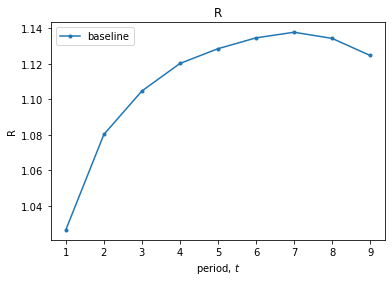

In [4]:
# plot the simulated behavior
for var in ('R',):
    fig,ax = plt.subplots()
    ax.plot(np.arange(model.par.T),np.mean(getattr(model.sim,var),axis=0),marker='.',label='baseline')
    ax.set(title=var,ylabel=var,xlabel='period, $t$')
    ax.legend()

In [5]:
final_s = model.sim.s[:,-1]
returnR = model.sim.R[:,1] # period 2 is index 1
print(f'The correlation is {np.corrcoef(returnR,final_s)[0,1]:2.3f}')
print('A positive correlation suggests that consumers who experience luck in the risky asset marked end up with higher wealth later in life.')
print('This indicates that capital returns potentially play a role in shaping wealth inequality.')

The correlation is 0.477
A positive correlation suggests that consumers who experience luck in the risky asset marked end up with higher wealth later in life.
This indicates that capital returns potentially play a role in shaping wealth inequality.


In [6]:
# As more initially wealthy consumers will invest more in the risky asset, and tend to have more wealth later in life, we could imagine that the correlation above is driven by initial wealth differences.
# To test this hypothesis, we could simulate a model in which all agents are initialized with the same level of wealth, say 1.0
model_same_init = model.copy()
model_same_init.sim.init_s[:] = 1.0
model_same_init.simulate()

final_s = model_same_init.sim.s[:,-1]
returnR = model_same_init.sim.R[:,1] # period 2 is index 1
print(f'The correlation is {np.corrcoef(returnR,final_s)[0,1]:2.3f} in this case. So still positive, and even a bit larger than before.')

The correlation is 0.482 in this case. So still positive, and even a bit larger than before.


## Question 5
We will now add a tax of $\tau=0.15$ on capital gains. Since $R^a$ and $R^b_{t+1}$ are *gross* rates, the capital gains can be found by subtracting one from these. In general, if the gross rate is $R$, then the capital *gain* is $\max\{R-1,0\}$ and thus the capital gain tax is $\tau\cdot\max\{R-1,0\}$ where $R-\tau\cdot\max\{R-1,0\}$ can be thought of as a net-of-tax rate. 

To include this in the model, we modify equations (3) and (4) to
\begin{align*}
a_{t+1} &= R^a(1-x_t)w_t - \tau\cdot\max\{R-1,0\}(1-x_t)w_t \\
        &= (R^a-\tau\cdot\max\{R-1,0\})(1-x_t)w_t \\
b_{t+1} &= [R^b_{t+1}-\tau\cdot\max\{R^b_{t+1}-1,0\}]x_tw_t.
\end{align*}

## Question 6
Adding the tax from above requires modifications to both the solution and simulation modules. Everything is done through the transition functions.

In [7]:
model_tax = model.copy()
model_tax.par.tau = 0.15
model_tax.solve()
model_tax.simulate()

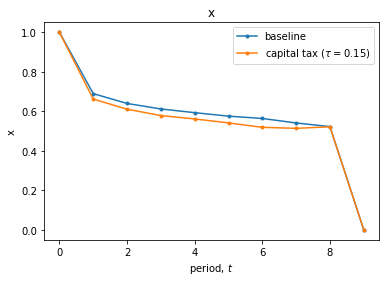

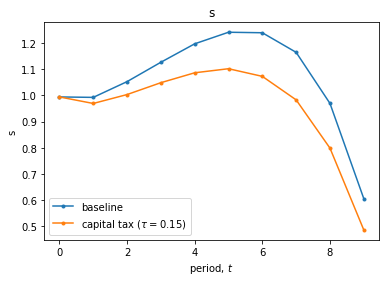

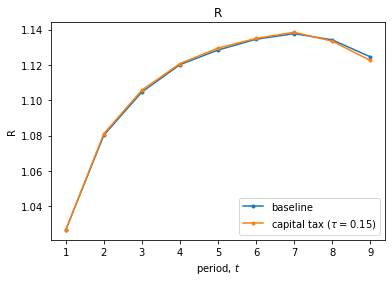

In [8]:
# plot the simulated behavior
for var in ('x','s','R'):
    fig,ax = plt.subplots()
    ax.plot(np.arange(model.par.T),np.mean(getattr(model.sim,var),axis=0),marker='.',label='baseline')
    ax.plot(np.arange(model_tax.par.T),np.mean(getattr(model_tax.sim,var),axis=0),marker='.',label='capital tax ($\\tau=0.15$)')
    ax.set(title=var,ylabel=var,xlabel='period, $t$')
    ax.legend()

In [9]:
final_s_tax = model_tax.sim.s[:,-1]
returnR_tax = model_tax.sim.R[:,1]
print(f'The correlation is now {np.corrcoef(returnR_tax,final_s_tax)[0,1]:2.3f}')
print(f'suggesting that the tax itself did not change the link significantly. \nThe gained tax revenue could, however, be used to re-distribute to consumers with fewer resources.')

The correlation is now 0.486
suggesting that the tax itself did not change the link significantly. 
The gained tax revenue could, however, be used to re-distribute to consumers with fewer resources.


## Question 7
We now calculate the additional level of wealth that we need to initiate tax payers with to make them indifferent between the two regimes.

In [10]:
from consav.linear_interp import interp_2d_vec
model_base = model
model_tax_comp = model_tax.copy()
init_s = model_base.sim.init_s[:].copy()

def obj_comp(wealth_comp,model_base,model_tax_comp,init_s,do_simulate=True,do_print = False):
    if do_simulate:
        # update initial wealth and re-simulate tax model
        model_tax_comp.sim.init_s[:] = init_s + wealth_comp
        model_tax_comp.simulate()

        # calculate welfare in both models
        par = model_base.par
        discount = par.beta**np.arange(par.T)  # discount the simulated sum of utility from consumption

        base = np.mean(np.sum(discount * model_base.util(model_base.sim.c),axis=1))
        new = np.mean(np.sum(discount * model_tax_comp.util(model_tax_comp.sim.c),axis=1))
    else:
        # interpolate the initial value function for all
        par = model_base.par
        t = 0
        base = np.nan + np.ones(par.simN)
        new = np.nan + np.ones(par.simN)
        interp_2d_vec(par.s_grid,par.Rb_grid,model_base.sol.V[t,0]    ,init_s              ,model_base.sim.init_Rb,base)
        interp_2d_vec(par.s_grid,par.Rb_grid,model_tax_comp.sol.V[t,0],init_s + wealth_comp,model_base.sim.init_Rb,new)
        base = np.mean(base)
        new = np.mean(new)
        
    # return difference
    if do_print: print(wealth_comp,new,base)
    return new - base


est = root_scalar(obj_comp, args=(model_base,model_tax_comp,init_s), bracket=(0.0,1.0),x0=0.5, method='brentq')

compensation = est.root
print(f'Compensation for capital tax is {compensation:.3f}. Since income is 1, this is worth around 10% of income')
print(f'Welfare difference is {obj_comp(compensation,model_base,model_tax_comp,init_s):.7f}')

# alternative: using interpolation ( and 1 as initial wealth, since many does that)
est_avg = root_scalar(obj_comp, args=(model_base,model_tax_comp,init_s,False), bracket=(0.0,2.0),x0=1.0, method='brentq')

compensation_avg = est_avg.root
print('Alternative, using interpolation.')
print(f'Compensation for capital tax is {compensation_avg:.3f}.')
print(f'Welfare difference is {obj_comp(compensation_avg,model_base,model_tax_comp,init_s,False):.7f}')

Compensation for capital tax is 0.109. Since income is 1, this is worth around 10% of income
Welfare difference is 0.0000000
Alternative, using interpolation.
Compensation for capital tax is 0.123.
Welfare difference is -0.0000000


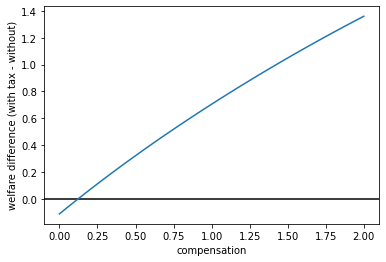

In [11]:
fig,ax = plt.subplots()
ax.axhline(0,color='black',linestyle='-')
ax.plot(np.linspace(0,2,50),[obj_comp(wealth_comp,model_base,model_tax_comp,init_s,do_simulate=False) for wealth_comp in np.linspace(0,2,50)]);
ax.set(xlabel='compensation',ylabel='welfare difference (with tax - without)');

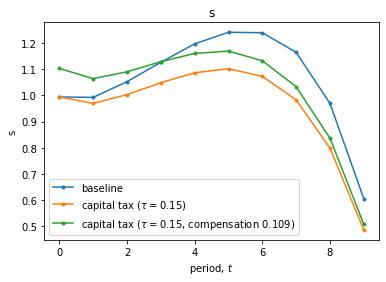

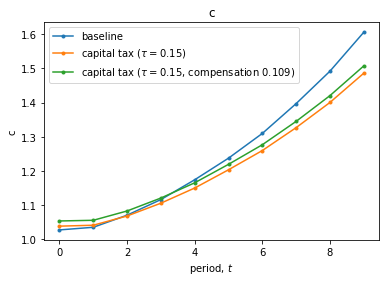

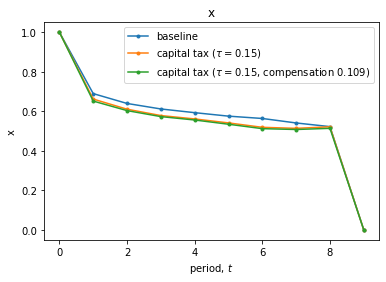

In [12]:
# plot the tree versions of the model
for var in ('s','c','x'):
    fig,ax = plt.subplots()
    ax.plot(np.arange(model.par.T),np.mean(getattr(model.sim,var),axis=0),marker='.',label='baseline')
    ax.plot(np.arange(model_tax.par.T),np.mean(getattr(model_tax.sim,var),axis=0),marker='.',label='capital tax ($\\tau=0.15$)')
    ax.plot(np.arange(model_tax_comp.par.T),np.mean(getattr(model_tax_comp.sim,var),axis=0),marker='.',label=f'capital tax ($\\tau=0.15$, compensation {compensation:2.3f})')
    ax.set(title=var,ylabel=var,xlabel='period, $t$')
    ax.legend()

## Question 8
Structural Estimation of $\theta=(\beta,\rho)$

In [13]:
def obj_func(theta,theta_names,mom_data,model,do_print=False):
    
    # printing
    if do_print: 
        print_str = ''
        for i,name in enumerate(theta_names):
            print_str += f'{name}={theta[i]:2.3f} '
        print(print_str,end='')
            
    # calculate moments from simulation
    mom_sim = simulate_moments(theta,theta_names,model,do_print=False)
    
    # equal weighting
    obj = np.sum((mom_data - mom_sim)**2)
    if do_print: print(f'-> obj = {obj:.6f}')

    # return objective and moments for plotting
    return obj

def simulate_moments(theta,theta_names,model,do_print=False):
        
    # update parameters
    for i,name in enumerate(theta_names):
        setattr(model.par,name,theta[i])
    
    # solve and simulate model with these parameters
    model.solve()
    model.simulate()
    
    # return moments from simulated data
    avg_s = np.mean(model.sim.s[:,4])
    avg_x = np.mean(model.sim.x[:,4])
    return np.array([avg_s,avg_x])

In [14]:
# moments in data
avg_s = 0.30
avg_x = 0.70
mom_data = np.array([avg_s,avg_x]) 

In [15]:
# call numerical optimizer
theta_names = ('beta','rho')
objective = lambda theta: obj_func(theta,theta_names,mom_data,model_tax,do_print=True)

DO_ESTIMATION = True 
if DO_ESTIMATION:
    theta_init = np.array([0.96,2.6])
    res = minimize(objective,theta_init,method='nelder-mead',tol=1e-4)
    print(res)

#  final_simplex: (array([[0.81892983, 2.91236347],
#        [0.81892969, 2.9123999 ],
#        [0.81893001, 2.91233813]]), array([0.0020083 , 0.00201568, 0.00202368]))
#            fun: 0.002008304577545972
#        message: 'Optimization terminated successfully.'
#           nfev: 77
#            nit: 33
#         status: 0
#        success: True
#              x: array([0.81892983, 2.91236347])


beta=0.960 rho=2.600 -> obj = 0.318892
beta=1.008 rho=2.600 -> obj = 0.686853
beta=0.960 rho=2.730 -> obj = 0.302958
beta=0.912 rho=2.730 -> obj = 0.108678
beta=0.864 rho=2.795 -> obj = 0.020200
beta=0.864 rho=2.925 -> obj = 0.020809
beta=0.768 rho=2.990 -> obj = 0.021338
beta=0.816 rho=2.925 -> obj = 0.002217
beta=0.816 rho=2.795 -> obj = 0.002271
beta=0.768 rho=2.925 -> obj = 0.021996
beta=0.840 rho=2.828 -> obj = 0.005390
beta=0.792 rho=2.893 -> obj = 0.008264
beta=0.828 rho=2.844 -> obj = 0.002460
beta=0.804 rho=2.876 -> obj = 0.004753
beta=0.822 rho=2.852 -> obj = 0.002037
beta=0.822 rho=2.982 -> obj = 0.002117
beta=0.828 rho=2.909 -> obj = 0.002555
beta=0.819 rho=2.921 -> obj = 0.002026
beta=0.819 rho=2.791 -> obj = 0.002051
beta=0.820 rho=2.839 -> obj = 0.002046
beta=0.821 rho=2.934 -> obj = 0.002058
beta=0.820 rho=2.863 -> obj = 0.002053
beta=0.820 rho=2.886 -> obj = 0.002033
beta=0.819 rho=2.880 -> obj = 0.002081
beta=0.820 rho=2.928 -> obj = 0.002047
beta=0.820 rho=2.916 -> o

## Question 9
**The average level of wealth** should be informative about especially the discount factor. The discount factor determines how much consumers care about the future. The more they care about the future, the more they will want to save for consumption later in life. Therefore, we would expect a positive correlation between the discount factor and the level of wealth mid life.

**The average share of wealth in risky assets** should be informative about especially the degree of risk aversion. There more risk averse consumers are, the less they would want to allocate in the risky asset, all else equal. We would therefore expect a negative correlation between the constant relative risk aversion and the share of wealth allocated to the risky asset. 
More risk averse consumers will also, however, tend to want to save more, increasing the level of wealth, to be able to smooth out marginal utility. This can impact the allocation of wealth into the risky asset too.

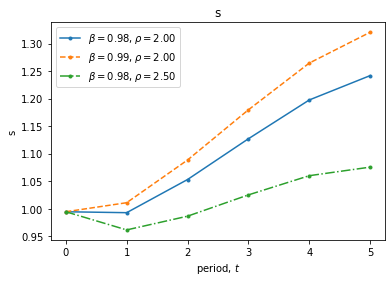

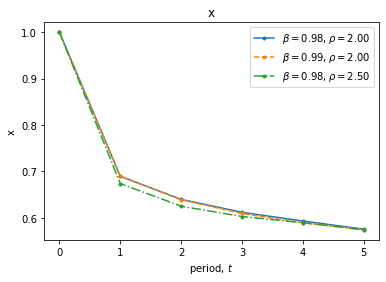

In [16]:
# we can show how the two moments vary with the two parameters (using the first baseline model and parameters)
model_beta = model.copy()
model_beta.par.beta = 0.99
model_beta.solve()
model_beta.simulate()

model_rho = model.copy()
model_rho.par.rho = 2.5
model_rho.solve()
model_rho.simulate()

for var in ('s','x'):
    fig,ax = plt.subplots()
    ax.plot(np.arange(6),np.mean(getattr(model.sim,var),axis=0)[:6],marker='.',label=f'$\\beta={model.par.beta:2.2f},\\rho={model.par.rho:2.2f}$')
    ax.plot(np.arange(6),np.mean(getattr(model_beta.sim,var),axis=0)[:6],marker='.',linestyle='--',label=f'$\\beta={model_beta.par.beta:2.2f},\\rho={model_beta.par.rho:2.2f}$')
    ax.plot(np.arange(6),np.mean(getattr(model_rho.sim,var),axis=0)[:6],marker='.',linestyle='-.',label=f'$\\beta={model_rho.par.beta:2.2f},\\rho={model_rho.par.rho:2.2f}$')
    ax.set(title=var,ylabel=var,xlabel='period, $t$')
    ax.legend()

## Question 10
The new state transitions as 
\begin{equation}
r_{t+1} = \begin{cases}
            1 & \text{with prob. } p(r_t) \\
            0 & \text{with prob. } 1-p(r_t)
          \end{cases}
\end{equation}
where 
\begin{equation}
p(r_{t}) = \begin{cases}
            0.1 & \text{if } r_t=0 \\
            0.8 & \text{if } r_t=1
          \end{cases}
\end{equation}

## Question 11

In [17]:
model_new = model_tax.copy() 
model_new.par.beta = 0.819
model_new.par.rho = 2.91

model_new.par.Nr = 2
model_new.allocate()

model_new.solve()

The risky return is 1.020 at this grid point.


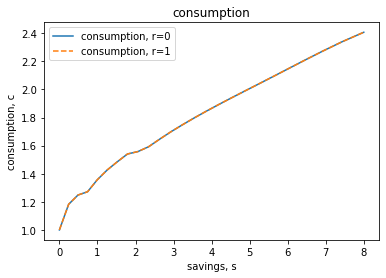

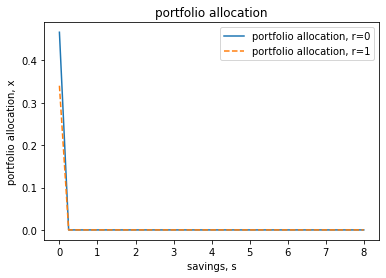

In [18]:
t = 0
idx_Rb = 8 # 9th point in the grid

print(f'The risky return is {model_new.par.Rb_grid[idx_Rb]:2.3f} at this grid point.')

fig,ax = plt.subplots()
ax.plot(model_new.par.s_grid,model_new.sol.c[t,0,:,idx_Rb],label='consumption, r=0')
ax.plot(model_new.par.s_grid,model_new.sol.c[t,1,:,idx_Rb],linestyle='--',label='consumption, r=1')
ax.set(title='consumption',xlabel='savings, s',ylabel='consumption, c')
ax.legend();

fig,ax = plt.subplots()
ax.plot(model_new.par.s_grid,model_new.sol.x[t,0,:,idx_Rb],label='portfolio allocation, r=0')
ax.plot(model_new.par.s_grid,model_new.sol.x[t,1,:,idx_Rb],linestyle='--',label='portfolio allocation, r=1')
ax.set(title='portfolio allocation',xlabel='savings, s',ylabel='portfolio allocation, x')
ax.legend();

## Question 12
Simulating the new model
We will introduce randomness in the simulation such that with probability $p(r_t)$ the economy will be in a recession in the following period.
To do this ww will use that if $U\sim Uniform(0,1)$ is a random uniform variable on $[0,1]$ then $P(U\leq p(r_t))=p(r_t)$. We will use this and draw uniform random variables on the unit interval and store it in `sim.draws_r` and then check in the simulation module if this is less than $p(r_t)$. If so, we will let $r_{t+1}=1$.

Since the recession is not an individual-specific state but a global economy wide shock we will only draw $T$ shocks and not one for each consumer. Likewise, we can choose to store the recession variable as a common variable in `sim.r` but I will store it (identically) for each consumer so that I can easily plot the trajectory along with individual variables below.

To initialize all consumers in a non-recession state, I include `sim.init_r = np.zeros(par.simN,dtype=np.int_)` in the `allocate` function.

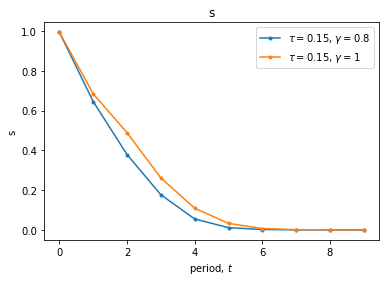

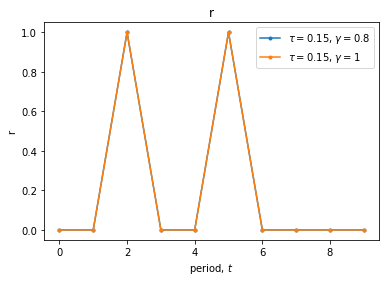

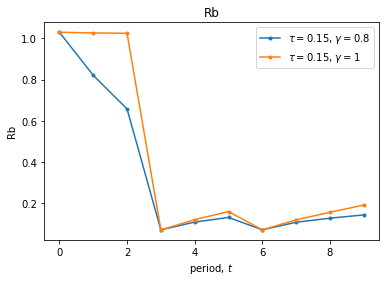

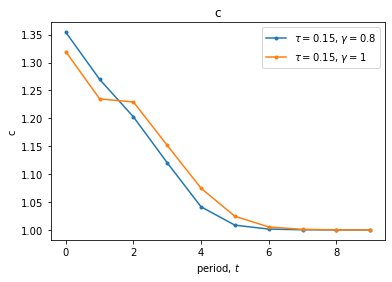

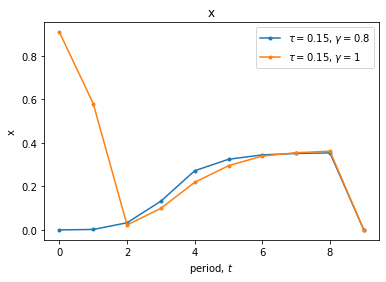

In [19]:
model_new.simulate()

model_new1 = model_new.copy()
model_new1.par.gamma = 1.0
model_new1.solve()
model_new1.simulate()

for var in ('s','r','Rb','c','x'):
    fig,ax = plt.subplots()
    ax.plot(np.arange(model_new.par.T),np.mean(getattr(model_new.sim,var),axis=0),marker='.',label=f'$\\tau=0.15$, $\\gamma=0.8$')
    ax.plot(np.arange(model_new1.par.T),np.mean(getattr(model_new1.sim,var),axis=0),marker='.',label='$\\tau=0.15$, $\\gamma=1$')
    ax.set(title=var,ylabel=var,xlabel='period, $t$')
    ax.legend()